<a href="https://colab.research.google.com/github/gregorywmorris/MLZoom2022/blob/main/midterm/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Auto-save / Auto-reload
%autosave 1

%load_ext autoreload
%autoreload 2

# Imports

In [2]:
import os

# for EDA
import requests
import wget
import pylab
import pandas as pd
import numpy as np

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt # https://scikit-plot.readthedocs.io/en/stable/Quickstart.htm
from IPython.display import display

# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import ComplementNB

# tuning and metrics
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_curve, precision_recall_curve, auc, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mutual_info_score

# Deployment
import bentoml

# still need?
from sklearn.metrics import mean_squared_error as rmse
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score


<a name="about_data"></a>
# Stroke Data

### An Appropriate Dataset
A seach for various stroke datasets that included health factors showed that the [Kaggle dataset](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset) was best suited. Numerous other stroke datasets are avaialbe but the lacked health factors needed. Datasets were often location based or even post stroke images. Neither are well suited for the the desired task.

### Limitations

* It is known that there are more factors for stroke prediction (such as [lab tests](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8686476/), lifestyle, etc.) than are avaialble in this data set.
  * However, [the most important factors](https://www.sciencedirect.com/science/article/pii/S2772442522000090) are in the dataset
* This data set was uploaded 2 years ago with no expectations of being updated.
* The source and accuracy to the data is unkown, a verified healthcare organization would be an ideal source for stroke data.

# Extract-Load

#### The Process


**Extract:** Data is extracted from [Kaggle](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset) to [GitHub](https://github.com/gregorywmorris/MLZoom2022/blob/main/midterm/healthcare-dataset-stroke-data.csvhttps://github.com/gregorywmorris/MLZoom2022/blob/main/midterm/healthcare-dataset-stroke-data.csv)

**Load:** Data is loaded to the notebook

**Transform:** Data is modified to suit and improve the model

<a name="extraction"></a>
### Load

In [ ]:
url = 'https://raw.githubusercontent.com/gregorywmorris/MLZoom2022/main/midterm/healthcare-dataset-stroke-data.csv'

In [ ]:
path = './data/'

if not os.path.exists(path):
    os.mkdir(path)
    print('Directory created.')
else:
    print('Directory already exists.')

wget.download(url,out = path)

In [3]:
df = pd.read_csv('./data/healthcare-dataset-stroke-data.csv')

<a name="init_eda"></a>
# Transform - Exploratory Data Analysis (EDA)

### **Overview**

In [4]:
df.head(3)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1


In [5]:
df.columns = df.columns.str.lower()

In [6]:
#@title Drop column 'id'
df = df.drop(columns='id')

In [7]:
#@title data Overview
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


In [8]:
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


Min age of 0.08, expected whole integers.

In [ ]:
#@title Distribution of all features are all highly positively skewed except for age which is slightly negatively skewed.
df.skew(numeric_only=True) # numeric_only=True else error

### **Label Value - df.stroke**

The target value to be predicted is df.stroke. This a a binary feature with 1 to indicate possitive for stroke and 0 to indicate not possitive for stroke.

In [9]:
df.stroke.value_counts()

stroke
0    4861
1     249
Name: count, dtype: int64

High imbalance with a low value count for the possitive prediction.

The label data is imbalanced, this is consistent with expectations as more people don't have stroke than do. Further consideration should be done on the negative affect this may have on the models. [Possible solutions](https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/).

In [10]:
#@title Sample Stroke Rate
stroke_rate = df.stroke.mean() # works because it is binary
round(stroke_rate,2)

0.05

Exact data on stroke prevelance is not avaible but some estimations can be made. From this [report](https://n.neurology.org/content/97/20_Supplement_2/S6) we know that the annual incident for stroke is ~3% in the US. Globally it varies by country economic status, with lower countries often having higher rates (see fig 2 in link). From that we can assume the 5% seen here is roughly representative of the real world stroke incident. 

### **df.age**

<Axes: xlabel='age'>

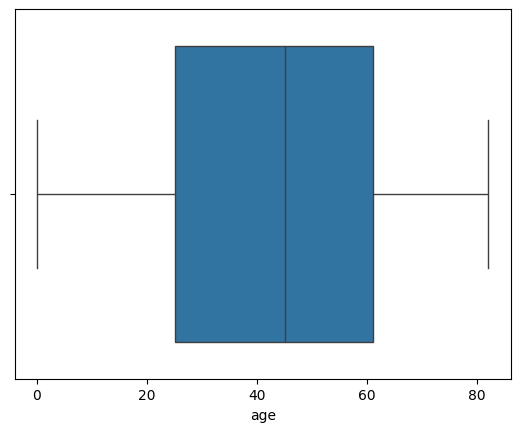

In [11]:
#@title No outliers in age
sns.boxplot(x=df.age)

<Axes: ylabel='Frequency'>

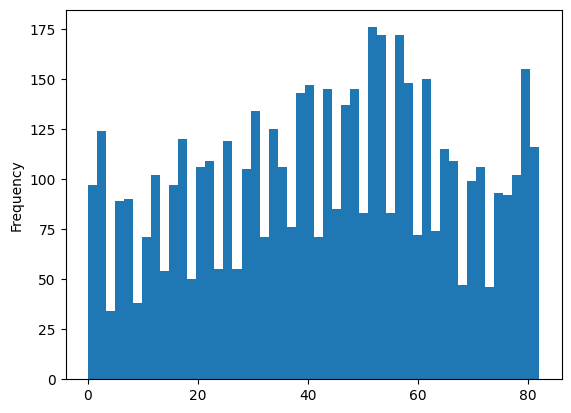

In [12]:
df.age.plot.hist(bins=50)

In [13]:
df.age.value_counts()

age
78.00    102
57.00     95
52.00     90
54.00     87
51.00     86
        ... 
1.40       3
0.48       3
0.16       3
0.40       2
0.08       2
Name: count, Length: 104, dtype: int64

Clarification on age [here](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset/discussion/223242?search=age), decimal places represent days.

### **df.bmi**

###### **Missing values**
[Missing Value Guide](https://www.analyticsvidhya.com/blog/2021/10/handling-missing-value/)

**Hypothesis**

There is a difference in the stroke grouping and missing values should be filled based on groups of either positive for stroke or not.

In [14]:
# bmi without missing values so that we can apply further analysis
# '~' reverses the bool and the returns the opposite of the bool value specified
bmi = df.bmi[~df['bmi'].isnull()]

In [15]:
# mean of the full sample
full_mean = bmi.mean()
full_mean

28.893236911794663

In [16]:
# 0 not a stroke and 1 is a stroke
stroke_bmi_0, stroke_bmi_1 =df.groupby('stroke')['bmi'].mean()
print('Stroke Negative:',stroke_bmi_0,' ','Stroke Positive:', stroke_bmi_1)

Stroke Negative: 28.823063829787234   Stroke Positive: 30.471291866028707


In [17]:
round((stroke_bmi_1-stroke_bmi_0)/stroke_bmi_1,2)

0.05

A difference of 5% in the bmi mean.

###### **Bootstrapping for Confidence Interval**

[Ditch p-values. Use Bootstrap confidence intervals instead](https://towardsdatascience.com/ditch-p-values-use-bootstrap-confidence-intervals-instead-bba56322b522)

In [18]:
def draw_bs_replicates(data,func,size):
    """creates a bootstrap sample, computes replicates and returns replicates array"""
    # Create an empty array to store replicates
    bs_replicates = np.empty(size)

    # Create bootstrap replicates as much as size
    for i in range(size):
        # Create a bootstrap sample
        bs_sample = np.random.choice(data,size=len(data))
        # Get bootstrap replicate and append to bs_replicates
        bs_replicates[i] = func(bs_sample)

    return bs_replicates

In [19]:
bs_replicates_bmi = draw_bs_replicates(bmi,np.mean,15000)
bs_replicates_bmi

array([28.78207374, 29.0642086 , 28.92892646, ..., 28.98967203,
       28.86799756, 29.03416174])

In [20]:
# Print BMI mean for stroke positive patients
print("Stroke BMI mean: " + str(stroke_bmi_1))

# Print the mean of bootstrap replicates
bs_mean = np.mean(bs_replicates_bmi)

print(f"Bootstrap replicates mean:"+ str(bs_mean))

Stroke BMI mean: 30.471291866028707
Bootstrap replicates mean:28.893377283900318


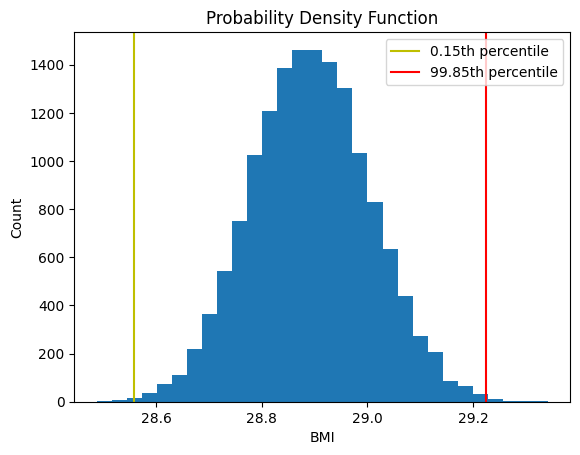

In [21]:
# Plot the PDF for bootstrap replicates as histogram
plt.hist(bs_replicates_bmi,bins=30)

# Showing the related percentiles
# a = 0.05,this equates to 2.5 on either end of the distribution
plt.axvline(x=np.percentile(bs_replicates_bmi,[0.15]), ymin=0, ymax=1,label='0.15th percentile',c='y')
plt.axvline(x=np.percentile(bs_replicates_bmi,[99.85]), ymin=0, ymax=1,label='99.85th percentile',c='r')

plt.xlabel("BMI")
plt.ylabel("Count")
plt.title("Probability Density Function")
plt.legend()
plt.show()

In [22]:
# Get the corresponding values of percentiles
conf_interval = np.percentile(bs_replicates_bmi,[99.85])

# Print the interval
print("The upper confidence interval: ",conf_interval)
print("Stroke BMI mean: " + str(stroke_bmi_1))

The upper confidence interval:  [29.22501699]
Stroke BMI mean: 30.471291866028707


The positive for stroke mean is outside our confidence interval. This indicates that with a 99% confidence level, the bmi for stroke positive patients is statistically significant.

###### **Manage Outliers**

[Outliers Guide](https://www.analyticsvidhya.com/blog/2021/05/detecting-and-treating-outliers-treating-the-odd-one-out/)

<Axes: xlabel='bmi'>

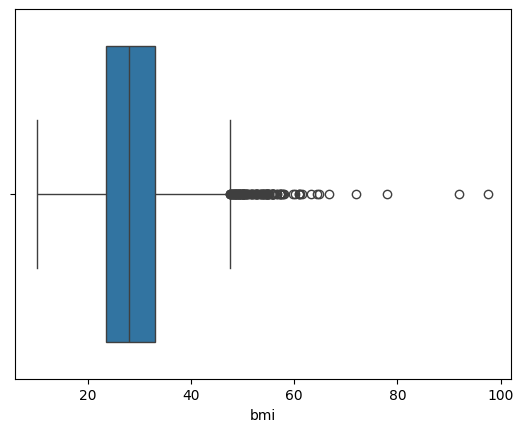

In [23]:
#@title Outliers noted in df.bmi
sns.boxplot(x=df.bmi)

In [24]:
df.bmi.value_counts(bins=15).sort_values()

(80.14, 85.96]        0
(85.96, 91.78]        0
(68.5, 74.32]         1
(74.32, 80.14]        1
(91.78, 97.6]         2
(62.68, 68.5]         4
(56.86, 62.68]       13
(51.04, 56.86]       43
(45.22, 51.04]       86
(10.212, 16.12]     100
(39.4, 45.22]       299
(33.58, 39.4]       690
(16.12, 21.94]      774
(27.76, 33.58]     1395
(21.94, 27.76]     1501
Name: count, dtype: int64

Some outliers represent natural variations in the population, and they should be left as is in the dataset. These are called true outliers. Other outliers are problematic and should be removed because they represent measurement errors, data entry or processing errors, or poor sampling.

Without a height metric, these outliers are assumed to be natural variants in the population.


[BMI](https://www.cancer.org/healthy/cancer-causes/diet-physical-activity/body-weight-and-cancer-risk/adult-bmi.html)

###### **Fill Missing Values**

Managing missing values:
Decision is to fill missing values.
* bmi for stroke positive patients is statistically signifigant and should be calculated separately for filling NAs.
* Previous iteration (first run of the notebook) shows that using median for each group produces more accurate models than using mean for each group.

In [25]:
bmi_0, bmi_1= df.groupby('stroke')['bmi']

In [26]:
# confirm grouping
bmi_0[0],bmi_1[0]

(0, 1)

In [27]:
bmi_0[1].mean()

28.823063829787234

In [28]:
bmi_1[1].mean()

30.471291866028707

<Axes: >

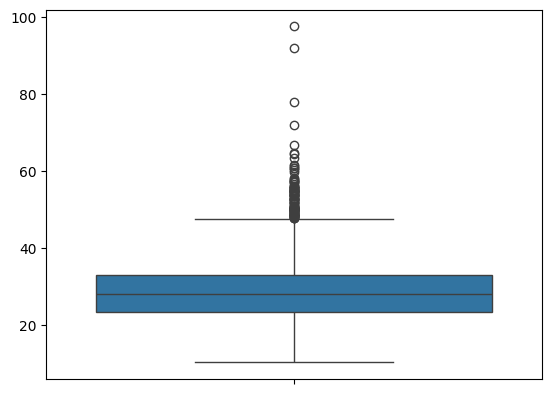

In [29]:
# box plot for bmi stroke negative
bmi_0 = np.array(bmi_0[1])
sns.boxplot(bmi_0)

<Axes: >

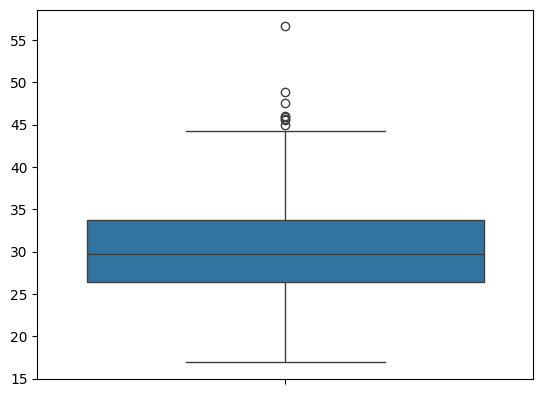

In [30]:
# box plot for bmi stroke possitive
bmi_1 = np.array(bmi_1[1])
sns.boxplot(bmi_1)

In [31]:
median_bmi_0, median_bmi_1 =df.groupby('stroke')['bmi'].median()

In [32]:
for i in range(len(df.bmi)):
    if (df.stroke[i] == 1 and np.isnan(df.bmi[i])):
      df.loc[i, "bmi"] = median_bmi_1
    elif (df.stroke[i] == 0 and np.isnan(df.bmi[i])):
      df.loc[i, "bmi"] = median_bmi_0

In [33]:
# Confirm there null values are filled.
df.bmi.isnull().value_counts()

bmi
False    5110
Name: count, dtype: int64

In [34]:
df.bmi.describe()

count    5110.000000
mean       28.871409
std         7.699951
min        10.300000
25%        23.800000
50%        28.000000
75%        32.800000
max        97.600000
Name: bmi, dtype: float64

###### **Obese Feature**

Obesity is [diagnosed](https://www.cancer.org/healthy/cancer-causes/diet-physical-activity/body-weight-and-cancer-risk/adult-bmi.html) for people with a bmi of 30 or greater.

I am creating a separate DataFrame (df2) to test generalized features such as obesity vs specific features like BMI.

In [35]:
df2 = df.copy()

In [36]:
df2['obese'] = df2['bmi'] >=30

In [37]:
df2 = df2.drop('bmi',axis=1)

In [38]:
df2.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,smoking_status,stroke,obese
0,Male,67.0,0,1,Yes,Private,Urban,228.69,formerly smoked,1,True
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,never smoked,1,False
2,Male,80.0,0,1,Yes,Private,Rural,105.92,never smoked,1,True
3,Female,49.0,0,0,Yes,Private,Urban,171.23,smokes,1,True
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,never smoked,1,False


In [ ]:
df.head()

### **df.avg_glucose_level**

###### **Outliers avg_glucose_level**

<Axes: xlabel='avg_glucose_level'>

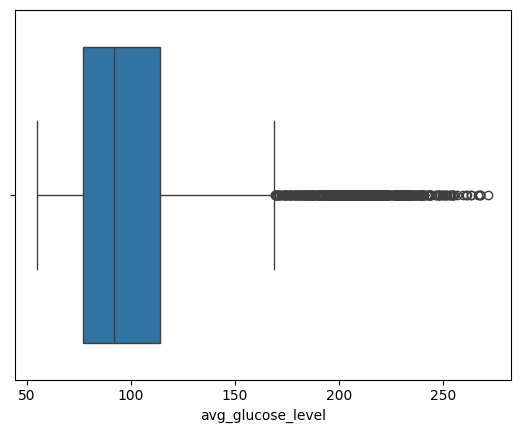

In [39]:
#@title Outliers noted in df.avg_glucose_level
sns.boxplot(x=df.avg_glucose_level)

In [40]:
df['avg_glucose_level'].describe()

count    5110.000000
mean      106.147677
std        45.283560
min        55.120000
25%        77.245000
50%        91.885000
75%       114.090000
max       271.740000
Name: avg_glucose_level, dtype: float64

In [41]:
df.avg_glucose_level.value_counts(bins=15).sort_values()

(257.299, 271.74]       10
(242.857, 257.299]      35
(170.651, 185.092]      61
(156.209, 170.651]      71
(228.416, 242.857]      88
(141.768, 156.209]     113
(185.092, 199.533]     119
(213.975, 228.416]     145
(127.327, 141.768]     150
(199.533, 213.975]     162
(112.885, 127.327]     370
(54.902, 69.561]       728
(98.444, 112.885]      746
(84.003, 98.444]      1142
(69.561, 84.003]      1170
Name: count, dtype: int64

Some outliers represent natural variations in the population, and they should be left as is in your dataset. These are called true outliers. Other outliers are problematic and should be removed because they represent measurement errors, data entry or processing errors, or poor sampling.

**Average glucose(a.k.a. blood sugar) level is measured though an A1C or HbA1c test.**

* For a normal person blood sugar can get up to 140 per the [American Diabetes Association](https://diabetesjournals.org/care/article/24/4/775/23438/Postprandial-Blood-Glucose), but diabetes is diagnosed when **AVERAGE** blood sugar is 140 or higher. However, people with Diabetes can get much higher than on this data set. Without a diabetes diagnosis it is not possible to determine if the outliers are inaccurate data. However, it is reasonable to interpet those above 140 as clearly having diabetes.

* Being below 140 does NOT signify someone does not have diabetes. They may simply be well controlled. Most type one diabetics aim for an average blood sugar of 140, while type two aim to be below that level.

* Prediabese determination is beyond the scope of this dataset.


###### **avg_glucose_level stroke comparison**

Reseach shows that Categorizing to above and below a bloodsugar limit may improve predictions.

 [Cleavland Clinic](https://my.clevelandclinic.org/health/diseases/9812-diabetes-and-stroke#:~:text=Your%20body%20can't%20make,Extra%20body%20weight.), [AHA Journal](https://www.ahajournals.org/doi/full/10.1161/01.str.0000115297.92132.84), [stroke.org.uk](https://www.stroke.org.uk/what-is-stroke/are-you-at-risk-of-stroke/diabetes), [Stroke.org - Diabetes](https://www.stroke.org/en/about-stroke/stroke-risk-factors/diabetes-and-stroke-prevention).

In [42]:
stroke_glucose_0, stroke_glucose_1 =df.groupby('stroke')['avg_glucose_level'].mean()
stroke_glucose_0, stroke_glucose_1 # 0 not a stroke and 1 is a stroke

(104.79551326887471, 132.54473895582328)

In [43]:
round((stroke_glucose_1-stroke_glucose_0)/stroke_glucose_1,2)

0.21

A 21% difference in the mean of avg_glucose_level of for stroke patients vs non-stroke.

In [44]:
stroke_gluc_0, stroke_gluc_1 =df.groupby('stroke')['avg_glucose_level']

In [45]:
# stroke negative
stroke_gluc_0[1].describe()

count    4861.000000
mean      104.795513
std        43.846069
min        55.120000
25%        77.120000
50%        91.470000
75%       112.830000
max       267.760000
Name: avg_glucose_level, dtype: float64

In [46]:
# stroke positive
stroke_gluc_1[1].describe()

count    249.000000
mean     132.544739
std       61.921056
min       56.110000
25%       79.790000
50%      105.220000
75%      196.710000
max      271.740000
Name: avg_glucose_level, dtype: float64

**Bootstrapping**

In [47]:
gluc = df['avg_glucose_level']

In [48]:
bs_replicates_gluc = draw_bs_replicates(gluc,np.mean,15000)

In [49]:
# Print empirical mean
print("Stroke avg_glucose_level mean: " + str(stroke_glucose_1))

# Print the mean of bootstrap replicates
bs_gluc_mean = np.mean(bs_replicates_gluc)

print(f"Bootstrap replicates mean:"+ str(bs_gluc_mean))

Stroke avg_glucose_level mean: 132.54473895582328
Bootstrap replicates mean:106.14898275642531


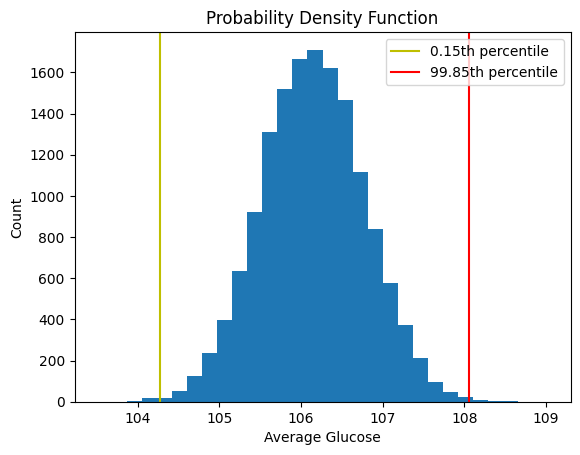

In [50]:
# Plot the PDF for bootstrap replicates as histogram
plt.hist(bs_replicates_gluc,bins=30)

# Showing the related percentiles
plt.axvline(x=np.percentile(bs_replicates_gluc,[0.15]), ymin=0, ymax=1,label='0.15th percentile',c='y')
plt.axvline(x=np.percentile(bs_replicates_gluc,[99.85]), ymin=0, ymax=1,label='99.85th percentile',c='r')

plt.xlabel("Average Glucose")
plt.ylabel("Count")
plt.title("Probability Density Function")
plt.legend()
plt.show()

In [51]:
# Get the corresponding values of percentiles
conf_interval = np.percentile(bs_replicates_gluc,[99.85])

# Print the interval
print("The confidence interval: ",conf_interval)
print("Stroke avg_glucose_level mean: " + str(stroke_glucose_1))

The confidence interval:  [108.05979401]
Stroke avg_glucose_level mean: 132.54473895582328


The diference between avg_glucose_level in stroke and non-stroke is statistically signifigant. The higher levels in one classification over another may justify creating a feature to identify those that would be diagnossed as diabetic based on their average glucose level. This does not neccessarily mean the others are not or were not, just identifies those that clearly are.

###### **Clearly Diabetes**

In [52]:
df2['diabetes'] = df['avg_glucose_level'] >= 140

In [53]:
df2 = df2.drop('avg_glucose_level',axis=1)

In [54]:
df2['diabetes'].value_counts()

diabetes
False    4289
True      821
Name: count, dtype: int64

In [55]:
df2.head(1)

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,smoking_status,stroke,obese,diabetes
0,Male,67.0,0,1,Yes,Private,Urban,formerly smoked,1,True,True


In [ ]:
df.head(1)

### **df.gender**

In [56]:
df.gender.value_counts()

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64

A single non binary gender is not useful. It is unclear if this is how someone idendified or if it was an error. It is best to drop it.

In [57]:
other = df[(df['gender']=='Other')].index
df = df.drop(other)
df2 = df2.drop(other)

In [58]:
df.gender.value_counts()

gender
Female    2994
Male      2115
Name: count, dtype: int64

In [ ]:
df2.gender.value_counts()

### **Other features**

In [59]:
df.ever_married.value_counts()

ever_married
Yes    3353
No     1756
Name: count, dtype: int64

In [60]:
df.work_type.value_counts()

work_type
Private          2924
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: count, dtype: int64

In [61]:
df.smoking_status.value_counts()

smoking_status
never smoked       1892
Unknown            1544
formerly smoked     884
smokes              789
Name: count, dtype: int64

In [62]:
df.residence_type.value_counts()

residence_type
Urban    2596
Rural    2513
Name: count, dtype: int64

### **Final Feature Overview**

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5109 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5109 non-null   object 
 1   age                5109 non-null   float64
 2   hypertension       5109 non-null   int64  
 3   heart_disease      5109 non-null   int64  
 4   ever_married       5109 non-null   object 
 5   work_type          5109 non-null   object 
 6   residence_type     5109 non-null   object 
 7   avg_glucose_level  5109 non-null   float64
 8   bmi                5109 non-null   float64
 9   smoking_status     5109 non-null   object 
 10  stroke             5109 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 479.0+ KB


In [64]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5109 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gender          5109 non-null   object 
 1   age             5109 non-null   float64
 2   hypertension    5109 non-null   int64  
 3   heart_disease   5109 non-null   int64  
 4   ever_married    5109 non-null   object 
 5   work_type       5109 non-null   object 
 6   residence_type  5109 non-null   object 
 7   smoking_status  5109 non-null   object 
 8   stroke          5109 non-null   int64  
 9   obese           5109 non-null   bool   
 10  diabetes        5109 non-null   bool   
dtypes: bool(2), float64(1), int64(3), object(5)
memory usage: 409.1+ KB


In [68]:
df_dummies = pd.get_dummies(df)
df2_dummies = pd.get_dummies(df2)

###### Review of inter-feature correlation and Data skew

In [65]:
from scipy.stats import pearsonr

def pValue_corr(df, numeric_only=True):
    # Calculate Pearson correlation coefficients
    corr_matrix = df.corr(numeric_only=numeric_only)

    # Calculate the p-values using scipy's pearsonr
    pvalue_matrix = df.corr(method=lambda x, y: pearsonr(x, y)[1])

    # Create a mask to hide the upper triangle (optional)
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    # Correlation heatmap
    plt.subplots(figsize=(20,16))
    mask = np.triu(np.ones_like(df.corr())) # triangle mask to hide duplicates
    sns.heatmap(df.corr(),cmap="coolwarm", annot=True, mask=mask)
    plt.title("Correlation Heatmap")

    # P-values heatmap
    plt.figure(figsize=(20, 16))
    sns.heatmap(pvalue_matrix, annot=True, fmt=".4f", cmap="coolwarm", mask=mask, square=True)
    plt.title("P-Value Heatmap")
    plt.show()

#### correlation matrix

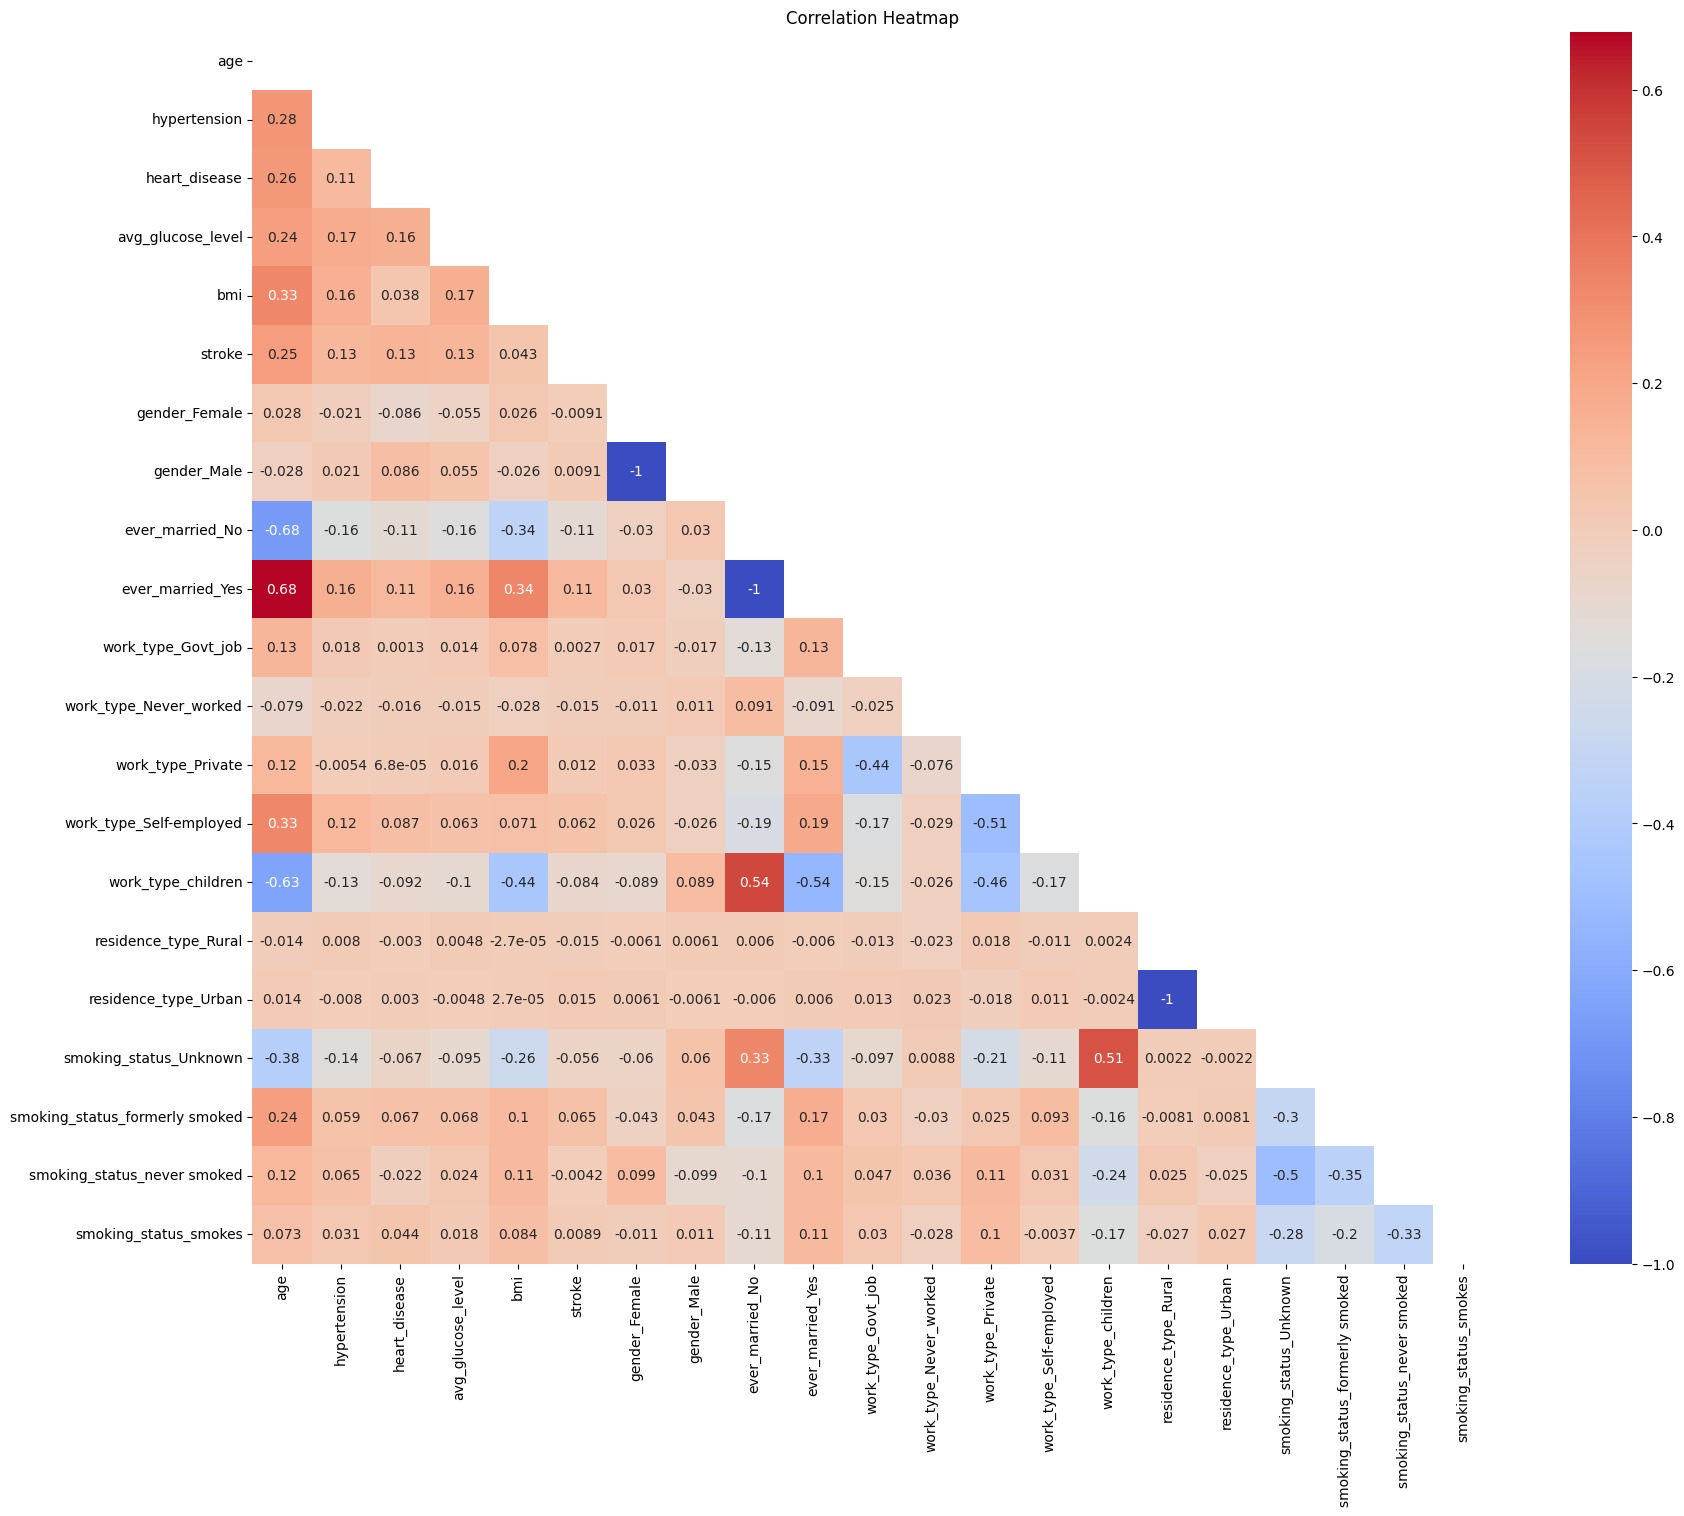

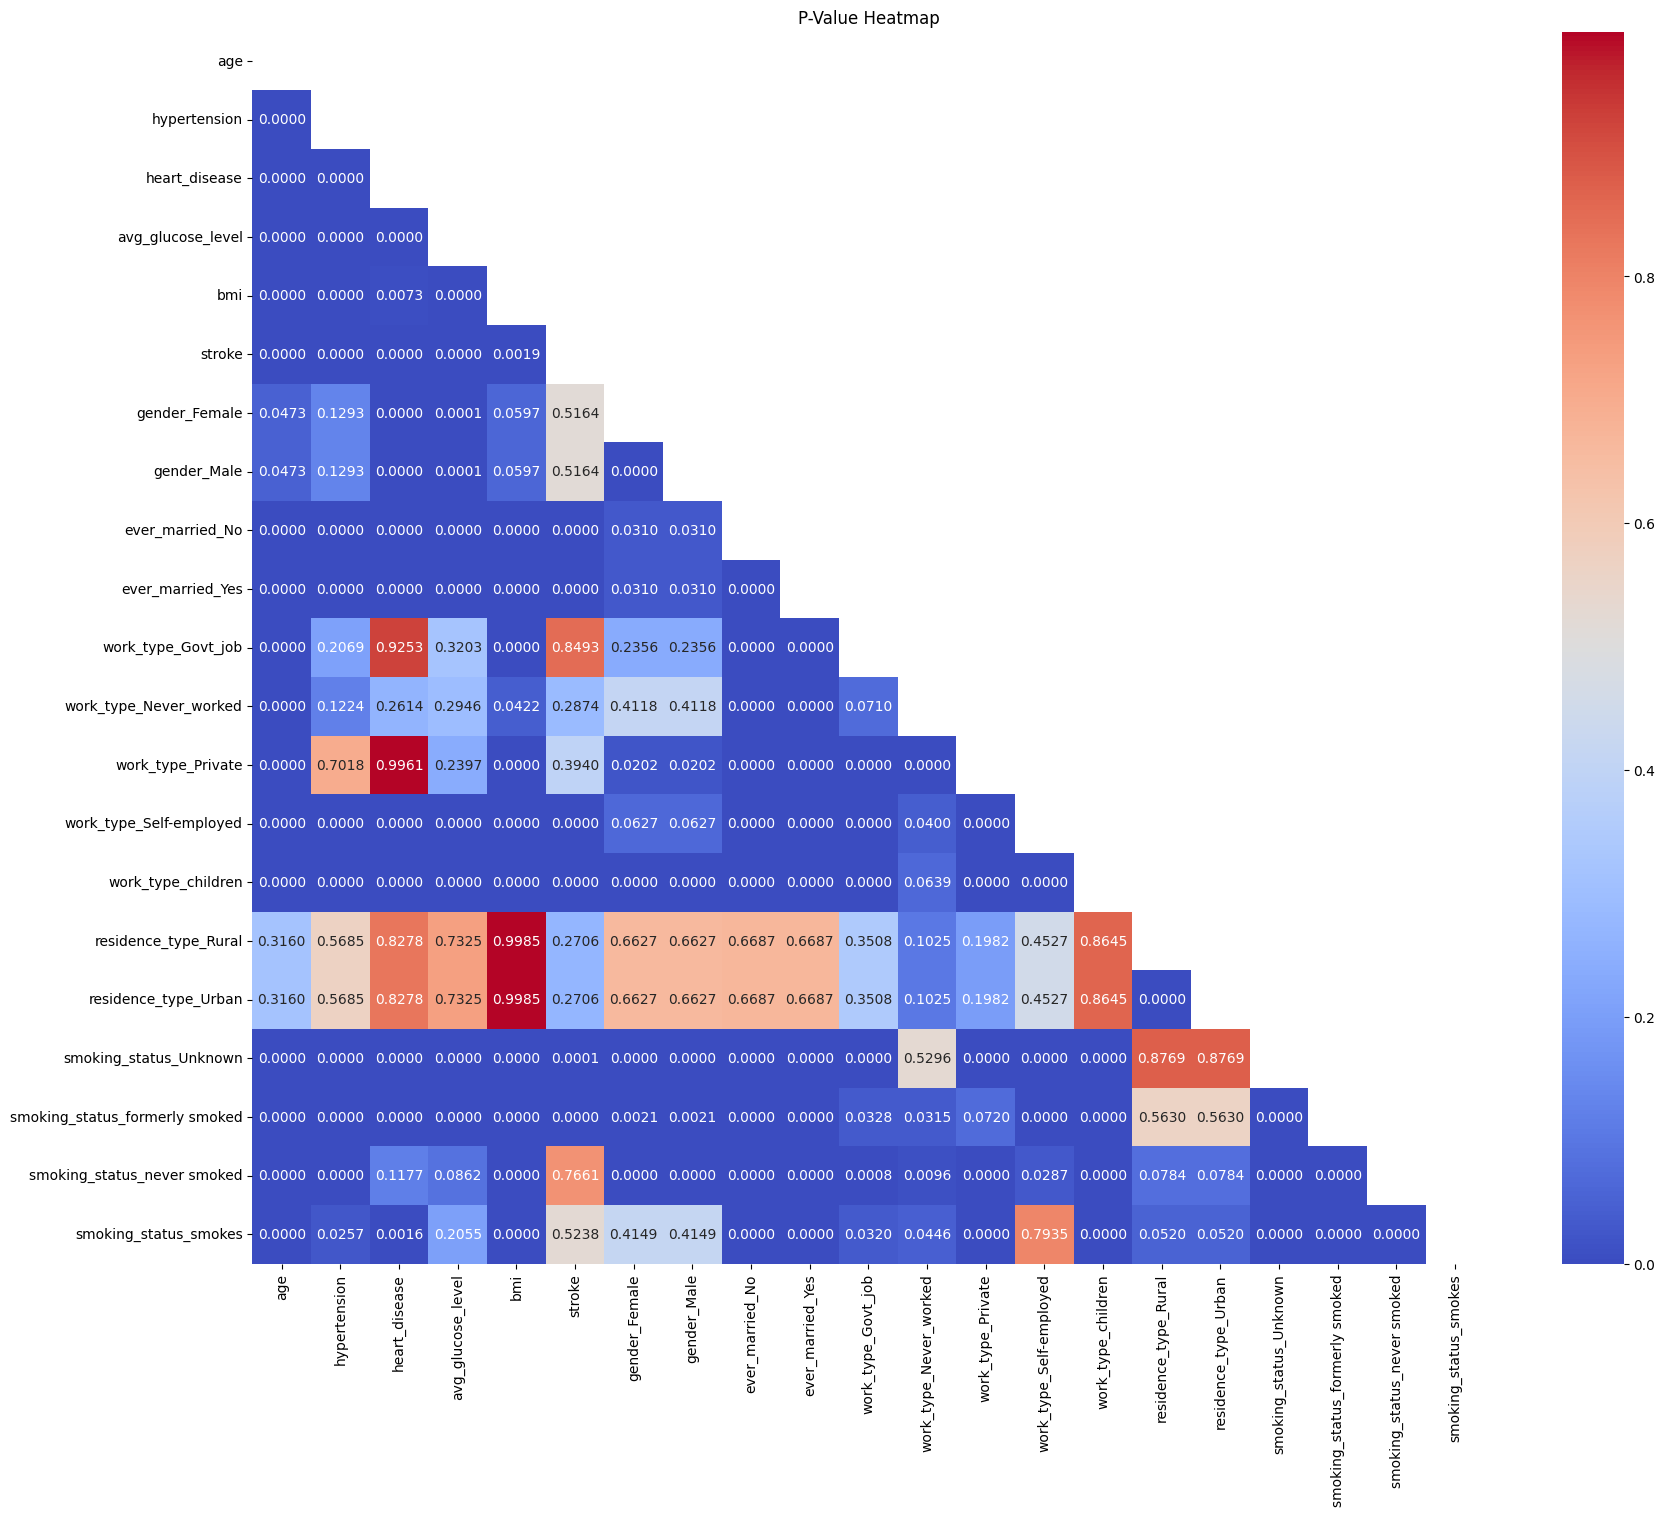

In [69]:


pValue_corr(df_dummies)

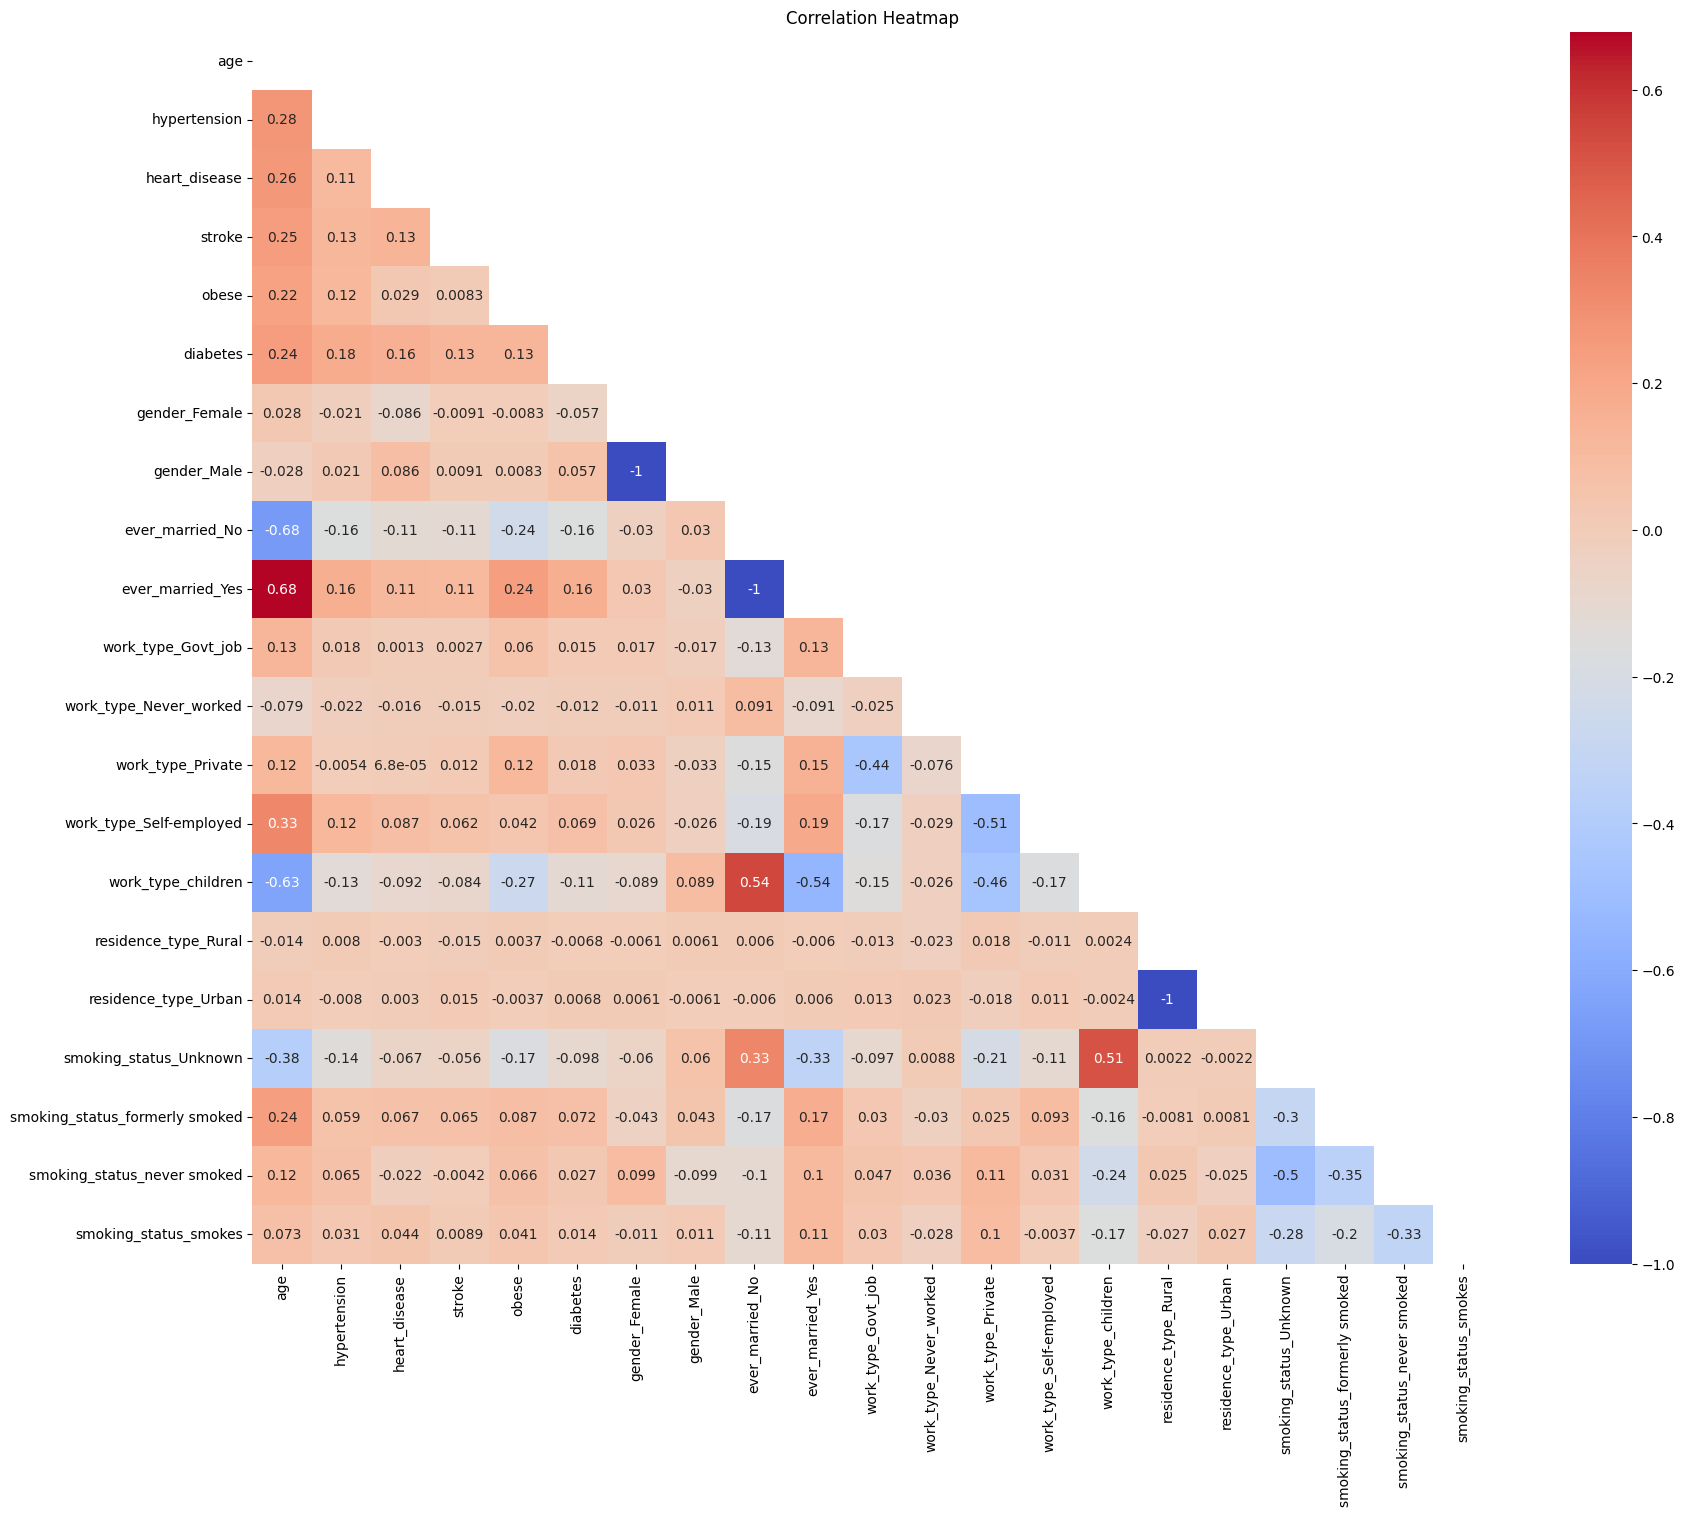

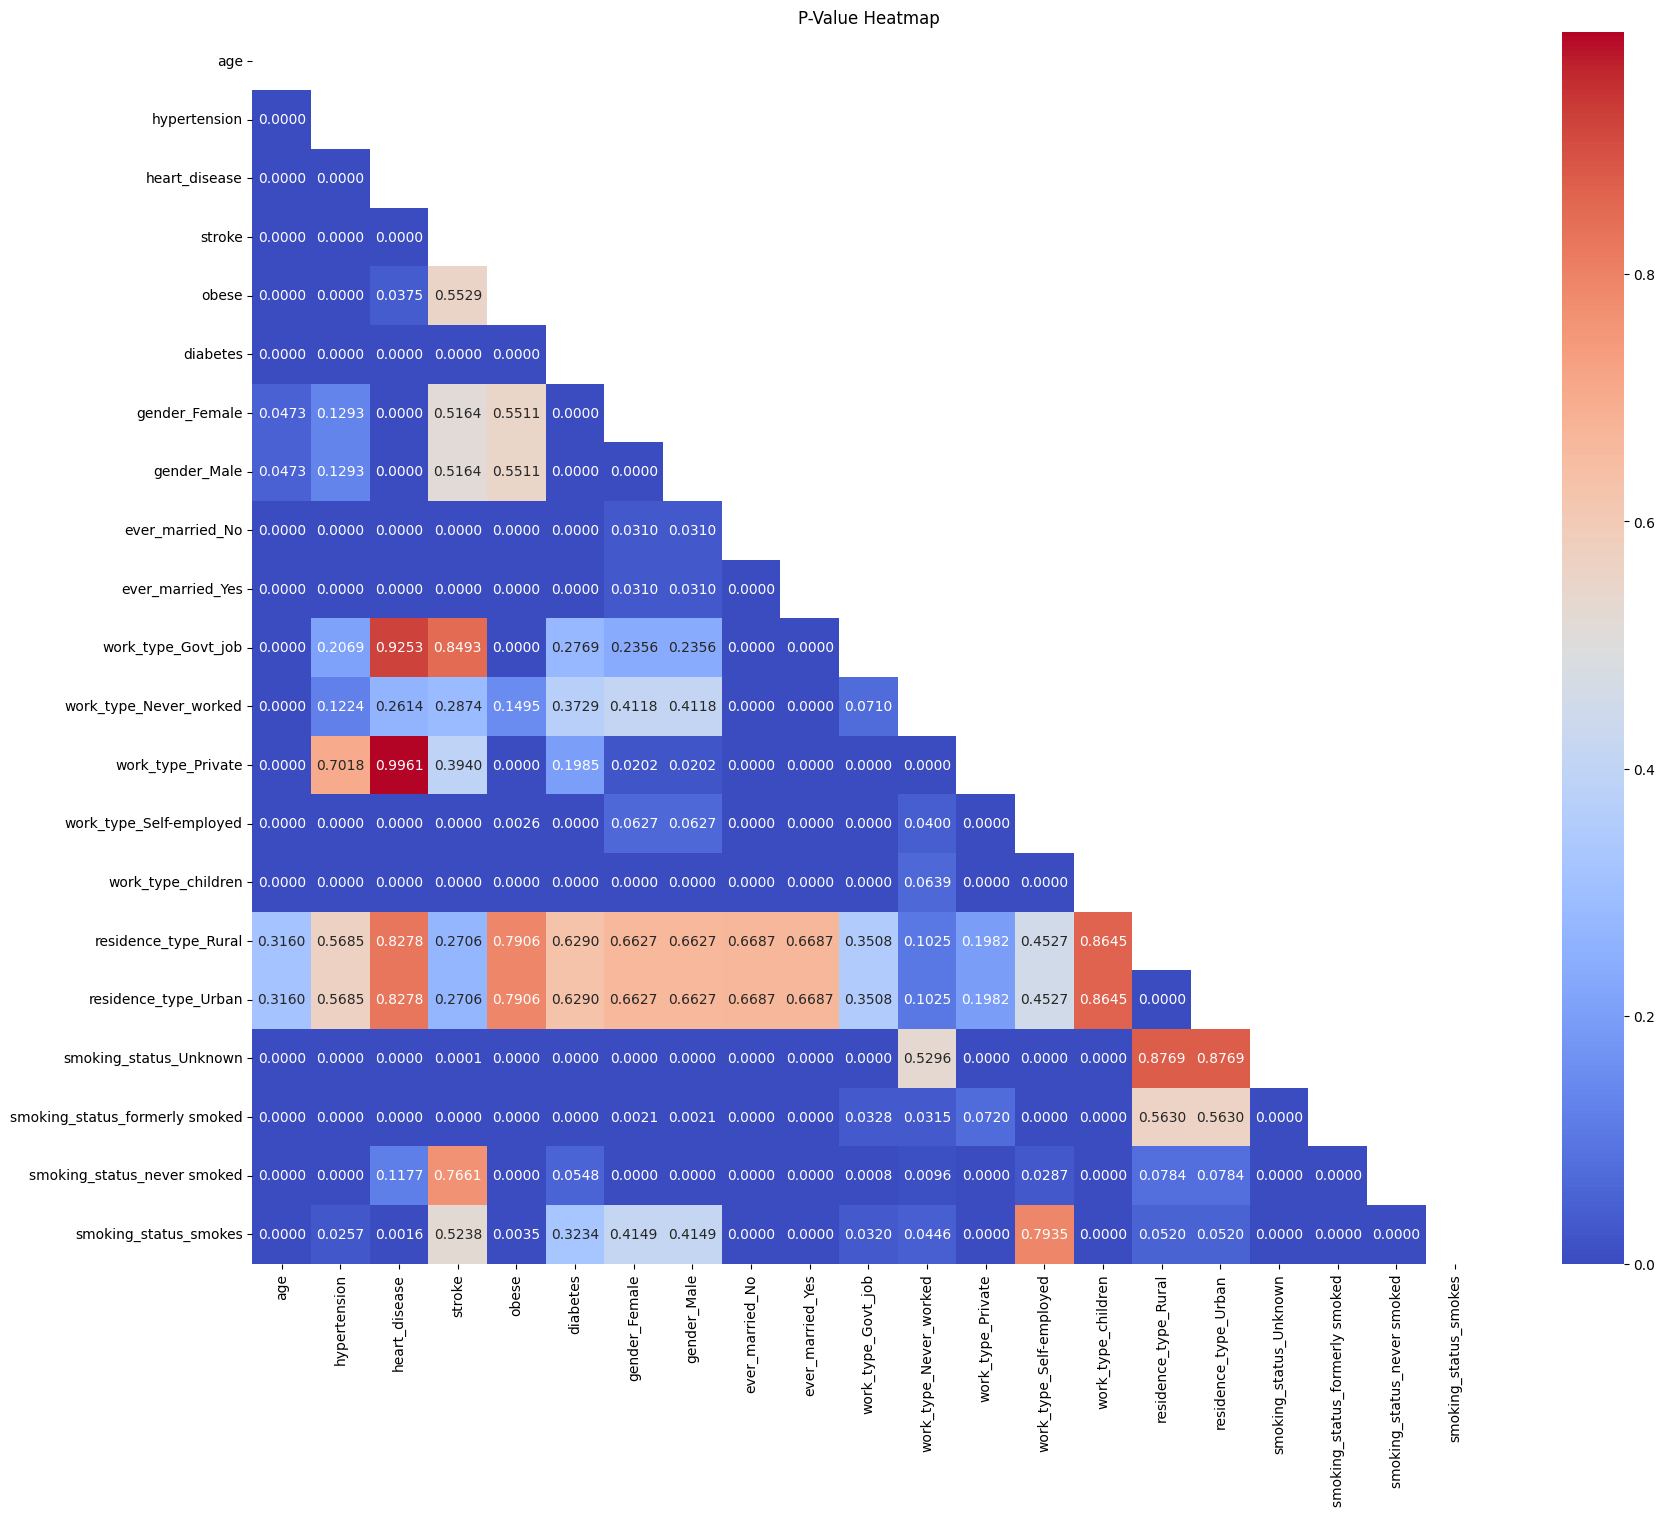

In [70]:
pValue_corr(df2_dummies)

#### Data Skew

In [ ]:
df.skew().sort_values(ascending=False)

In [ ]:
df2.skew().sort_values(ascending=False)

Much of the data is far from a Gaussian (normal) distribution. This may negatively affect model performance and should be reviewed for improving the moel later. Also consider [Your Dataset Is Imbalanced? Do Nothing!](https://towardsdatascience.com/your-dataset-is-imbalanced-do-nothing-abf6a0049813)

<a name="baseline"></a>
# Modeling

The modeling proccess is to first test possable viable models, then select the best models, and create a baseline to compare the tuning process against.

**Linear Regression** is a poor choice for clasification output problems and better suited for continuous output problems. While the label is binary the model could provide values outside of that range.

Researching ML models and the general concesses from ML engineers show the following models best for our label which is a binary classifier (stroke 1 or 0). There are numerous articles and research papers but this [article](https://towardsdatascience.com/pros-and-cons-of-various-classification-ml-algorithms-3b5bfb3c87d6) and this [article](https://towardsdatascience.com/top-10-binary-classification-algorithms-a-beginners-guide-feeacbd7a3e2) sum up the reasoning.

### Data Prep

#### DF

In [ ]:
#@title Split: df_train / df_val

df_full_train, df_val = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_test = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.stroke.values
y_val = df_val.stroke.values
y_test = df_test.stroke.values

del df_train['stroke']
del df_val['stroke']
del df_test['stroke']

In [ ]:
#@title x_train

train_dict = df_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
x_train = dv.fit_transform(train_dict)


In [ ]:
x_train.shape, y_train.shape

In [ ]:
#@title x_val

val_dict = df_val.to_dict(orient='records')
x_val = dv.transform(val_dict)

In [ ]:
#@title x_test

test_dict = df_test.to_dict(orient='records')
x_test = dv.transform(test_dict)

#### DF2

In [ ]:
#@title Split: df2_train / df2_val / df2_test

df2_full_train, df2_val = train_test_split(df2, test_size=0.2, random_state=1)
df2_train, df2_test = train_test_split(df2_full_train, test_size=0.25, random_state=1)

df2_train = df2_train.reset_index(drop=True)
df2_val = df2_val.reset_index(drop=True)
df2_test = df2_test.reset_index(drop=True)

y_train2 = df2_train.stroke.values
y_val2 = df2_val.stroke.values
y_test2 = df2_test.stroke.values

del df2_train['stroke']
del df2_val['stroke']
del df2_test['stroke']

In [ ]:
#@title x_val2

val2_dict = df2_val.to_dict(orient='records')
x_val2 = dv.transform(val2_dict)

In [ ]:
#@title x_train2

train2_dict = df2_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
x_train2 = dv.fit_transform(train2_dict)


In [ ]:
#@title x_test2

test2_dict = df2_test.to_dict(orient='records')
x_test2 = dv.transform(test2_dict)

### Model Comparison

In [ ]:
#@title def model_run(models)

def model_run(models,x_train,y_train,x_val,y_val):
  for name, model in models:
      model = model
      model.fit(x_train, y_train)

      print(" ")
      print("Model: ",name)
      print('Validation Accuracy: ', accuracy_score(y_val, model.predict(x_val)))
      print('Training Accuracy: ', accuracy_score(y_train, model.predict(x_train)))
      print(" ")

      plt.figure()
      cf_matrix = confusion_matrix(y_val, model.predict(x_val))
      sns.heatmap(cf_matrix, annot = True, fmt = 'g', cmap = sns.cubehelix_palette(as_cmap=True))
      plt.title('Confusion Matrix: {}'.format(name))
      plt.xticks([0.5, 1.5], ['Predicted Non-Stroke', 'Predicted Stroke'])
      plt.yticks([0.5, 1.5], ['Actual Non-Stroke', 'Actual Stroke'])
      plt.show()

      print(" ")

      skplt.metrics.plot_roc(y_val, model.predict_proba(x_val))
      plt.title('ROC Curves: {}'.format(name))
      plt.show()

In [ ]:
#@title Model Selection
start_models = [('Logistic Regression', LogisticRegression(max_iter=4000,random_state=10)), # max_iter=4000 due to convergence error
          ('Decision Tree Classifier', DecisionTreeClassifier(random_state=10)),
          ('Random Forest', RandomForestClassifier(random_state=10)),
          ('Linear Discriminant Analyzer', LinearDiscriminantAnalysis()),
          ('Ada Boost', AdaBoostClassifier(random_state=1)),
          ('KNN', KNeighborsClassifier()),
          ('Support Vector Machine', SVC(probability =True, random_state=10)),
          ('XG Boost', XGBClassifier(random_state=10)),
          ('Cat Boost', CatBoostClassifier(logging_level = 'Silent')),
          ('Naive Bayes', ComplementNB())]

Logisitc Regression interation increased to resolve [convergence error](https://stackoverflow.com/questions/62658215/convergencewarning-lbfgs-failed-to-converge-status-1-stop-total-no-of-iter)

#### DF all models

In [ ]:
#@title Run all models
model_run(start_models,x_train,y_train,x_val,y_val)

#### DF2 all models

In [ ]:
#@title Run all models 2
model_run(start_models,x_train2,y_train2,x_val2,y_val2)

Poor overall score, likely due to data imbalance. Actual stroke prediction is 82-89% accurate. With SVM having the best performance.

### SMOTE

Oversampling with SMOTE

In [ ]:
#@title def training_smote(x,y) - to address the stroke imbalance

# ONLY APPLY SMOTE TO TRAIN!
def training_smote(x,y):
    smt = SMOTE(random_state=42,sampling_strategy='minority')
    a, b = smt.fit_resample(x,y)

    return a, b

In [ ]:
x_train_smt, y_train_smt = training_smote(x_train, y_train)

In [ ]:
x_train_smt.shape

In [ ]:
x_train2_smt, y_train2_smt = training_smote(x_train2, y_train2)

In [ ]:
len(x_train2)

SMOTE is not able to generate data

### All Models

#### SMOTE DF all models

In [ ]:
#@title Run all models
model_run(start_models,x_train_smt,y_train_smt,x_val,y_val)

#### SMOTE DF2 all models

In [ ]:
#@title Run all models 2
model_run(start_models,x_train2_smt,y_train2_smt,x_val2,y_val2)

## Best Performing Models

While the score may not be the highest, these models were the best at predicting a stroke. The trade off is lower non-stroke accuracy. In the case of healthcare, we would rather over capture non-stroke than miss actual strokes.

The df2 (more generalized data) and the SMOTE data increased accuracy.

Naive Bayes had the best Stroke possiitive prediction but the non-stroke prediction was so poor I am not sure that it is usable in production.

In [ ]:
#@title Selected Models
best_models = [('Logistic Regression', LogisticRegression(max_iter=1000, random_state=10)),
          ('Linear Discriminant Analyzer', LinearDiscriminantAnalysis()),
          ('Support Vector Machine', SVC(probability = True,random_state=10)),
          ('Naive Bayes', ComplementNB())]

In [ ]:
model_run(best_models, x_train2_smt,y_train2_smt,x_val2,y_val2)

<a name="tuning"></a>
# Tuning

The tuning process consists of adjusting and measuring model parameters, and, if needed, revisiting feature engineering.

**Best Preforming Model**


Comparison of the models in the variable `selected_models`:

* **Logistic Regression**, `LogisticRegression()`
  * Validation Accuracy:     ~0.729
  * Training Accuracy:       ~0.781
  * Stroke Possitive Missed: 8/52
* **Linear Discriminant Analyzer**, `LinearDiscriminantAnalysis()`
  * Validation Accuracy:     ~0.714
  * Training Accuracy:       ~0.782
  * Stroke Possitive Missed: 5/55
* **Support Vector Machine**, `SVC(probability = True)`
  * Validation Accuracy:     ~0.669
  * Training Accuracy:       ~0.763
  * Stroke Possitive Missed: 5/55
* **Naive Bays**, `ComplementNB()`
  * Validation Accuracy:     ~0.497
  * Training Accuracy:       ~0.733
  * Stroke Possitive Missed: 2/58

<a name="feat_imp"></a>
## Feature Importance - [article](https://machinelearningmastery.com/calculate-feature-importance-with-python/)

## Feature Importance Model

In [ ]:
my_list = [LogisticRegression(max_iter=4000, random_state=10),LinearDiscriminantAnalysis()]

In [ ]:
#@title Feature Rank
for model in my_list:
    rfe = RFECV(estimator=model,step=1,cv=5)
    rfe.fit(x_train2_smt,y_train2_smt)
    print(" ")
    print(model)
    print(" ")
    for j, col, in zip(range(df.shape[1]), df.columns):
      print(f'{col} selected= {rfe.support_[1]} rank= {rfe.ranking_[1]}')

None of the features show a higher rank than the others.

In [ ]:
#@title Get Feature Names

feat_names = dv.get_feature_names_out()

In [ ]:
#@title def feature_importance(model)
def feature_importance(model):
    # define the model
    model = model
    # fit the model
    model.fit(x_train2_smt, y_train2_smt)
    # get importance
    importance = model.coef_[0]
    # summarize feature importance
    for i,v in enumerate(importance):
        print(f'Feature: {feat_names[i]}',' ',f'Score: {v}\n')

In [ ]:
#@title Logistic Feature coefficients

feature_importance(LogisticRegression(max_iter=4000, random_state=10))

In [ ]:
#@title Linear Discriminant Feature coefficients

feature_importance(LinearDiscriminantAnalysis())

# plot feature importance
#pyplot.bar([x for x in range(len(importance))], importance)
#pyplot.show()

**NOTE:** Reading too much into coeficients can be dangerious as the relaitonships can be complex.

Heart_disease, Diabetes, and hypertension were all possitively correlated with stroke. This is consistent with studies showing that these diseases greatly increase your likelihood of having a stroke. [Cardiovascular risk factors](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4419105/) / [Diabetes and Stroke: Epidemiology, Pathophysiology, Pharmaceuticals and Outcomes](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5298897/#:~:text=Diabetes%20is%20a%20well%2Destablished,stroke%20with%20uncontrolled%20glucose%20levels.)

The second highest possitive coefficients is for work_type=children despte research showing that stroke in children is [rare](https://www.hopkinsmedicine.org/health/conditions-and-diseases/stroke/pediatric-stroke).

The obese feature may be confusing the models, as we are seeing inconsistent accounting for it, despite it being a known to increase the likelyhood of stroke. This may be a feature that is only positive when paired with other features. [Obesity and Stroke: Does the Paradox Apply for Stroke?](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7946563/).

The negative coeficient for smokes (in logistic regression) is also intersting, as we know it leads to hypertension and heart disease. It is likely only positive when combined with hypertension and/or heart disease.

In [ ]:
df2[df2.work_type == 'children'].stroke.value_counts()

It may be better to remove the children type and limit age to 18+; creating an adult only model. It is reasonable that children would need a model specific to them.

## Feature Importance Data

In [ ]:
#@title Sample Stroke Rate
stroke_rate = df.stroke.mean() # works because it is binary
round(stroke_rate,2)

In [ ]:
df2.info()

In [ ]:
categorical = ['gender','hypertension','heart_disease','ever_married','work_type','residence_type','smoking_status','obese','diabetes']

In [ ]:
#@title Feature Importance Breakdown

for c in categorical:
    print(c)
    df_group = df2.groupby(c).stroke.agg(['mean','count'])
    df_group['diff'] = df_group['mean'] - stroke_rate # difference between group and overall stroke rate
    df_group['risk'] = df_group['mean'] / stroke_rate # group risk relative to overall risk
    display(df_group)
    print('\n')

The most most interesting thing here is we can see that the stroke risk reletive to the group risk is consistent with expectations.

In [ ]:
def mutual_stroke(series):
    return mutual_info_score(series,df2['stroke'])

In [ ]:
mi = df2[categorical].apply(mutual_stroke)
mi.sort_values(ascending=False)

We can see that the categories are independant, this is expected.

In [ ]:
#@title Feature Stroke Correlation
df2.corr(numeric_only = True)['stroke'].sort_values(ascending=False).iloc[1:] # if using different dataframes, use df1.corrwith(df2)

**Note:** obese is a bool value and should not show in this list.

## Feature Importance Testing




**Hypothesis:** better prediction can be obtained by excluding children value.

In [ ]:
df2_adult = df2.copy()

In [ ]:
child = df2_adult[(df2_adult['work_type']=='Other')].index
df2_adult.drop(child, inplace=True)

In [ ]:
age18 = df2[(df['age']<18)].index
df2_adult.drop(age18,inplace=True)

In [ ]:
df2_adult.age.plot.hist(bins=50)

In [ ]:
#@title Split: x_train2_adult / x_val2_adult / x_test2_adult

df2_full_train_adult, x_val2_adult = train_test_split(df2_adult, test_size=0.2, random_state=1)
x_train2_adult, x_test2_adult = train_test_split(df2_full_train_adult, test_size=0.25, random_state=1)

x_train2_adult = x_train2_adult.reset_index(drop=True)
x_val2_adult = x_val2_adult.reset_index(drop=True)
x_test2_adult = x_test2_adult.reset_index(drop=True)

y_train2_adult = x_train2_adult.stroke.values
y_val2_adult = x_val2_adult.stroke.values
y_test2_adult = x_test2_adult.stroke.values

del x_train2_adult['stroke']
del x_val2_adult['stroke']
del x_test2_adult['stroke']

dv = DictVectorizer(sparse=False)

# df2_train_child
df2_train2_dict_adult = x_train2_adult.to_dict(orient='records')
x_train2_adult = dv.fit_transform(df2_train2_dict_adult)

# df2_x_val_adult
df2_val2_dict_adult = x_val2_adult.to_dict(orient='records')
x_val2_adult = dv.transform(df2_val2_dict_adult)

# x_test2_adult
df2_test2_dict_adult = x_test2_adult.to_dict(orient='records')
x_test2_adult = dv.transform(df2_test2_dict_adult)

In [ ]:
x_train2_adult_smt, y_train2_adult_smt = training_smote(x_train2_adult, y_train2_adult)

In [ ]:
# selected_models is defined at the end of the section Modeling
model_run(best_models,x_train2_adult_smt, y_train2_adult_smt,x_val2_adult,y_val2_adult)

All models did worse. Removing children had a negative affect.

<a name="modTune"></a>
## Model Tuning

### LogisticRegression Tunning
[Article](https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/)

In [ ]:
log_model = LogisticRegression(max_iter=4000, random_state=10)

In [ ]:
# define LogisticRegression and parameters
model = log_model
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01,0.001]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=10)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(x_train2, y_train2) # defined in the modeling section
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

As noted previously, we need possitive stroke prediction first and model statistics second. Using the above results gives us a guidline to test against but it is limited in that is looing at model performace and not taking into account possitive stroke prediction.

In [ ]:
# Final model comparison
log_model_opt = [('liblinear', LogisticRegression(max_iter=4000, random_state=10,C=0.1,penalty='l2',solver='liblinear')),
                 ('newton-cg', LogisticRegression(max_iter=4000, random_state=10,C=0.1,penalty='l2',solver='newton-cg')),
                 ('lbfgs', LogisticRegression(max_iter=4000, random_state=10,C=0.1,penalty='l2',solver='lbfgs')),
                 ('Default', LogisticRegression(max_iter=4000, random_state=10))]

In [ ]:
model_run(log_model_opt,x_train2_smt,y_train2_smt,x_val2,y_val2)

**Logistic Regression**, `LogisticRegression(max_iter=4000, random_state=10,C=0.1,penalty='l2',solver='liblinear')` is the best performing.

In [ ]:
#@title Optimized Log Model

log_model = LogisticRegression(max_iter=4000, random_state=10,C=0.1,penalty='l2',solver='liblinear')

### LinearDiscriminantAnalysis Tuning
[Article](https://machinelearningmastery.com/linear-discriminant-analysis-for-machine-learning/)

In [ ]:
lda_models = [('svd', LinearDiscriminantAnalysis(solver='svd')),
          ('lsqr', LinearDiscriminantAnalysis(solver='lsqr')),
          ('eigen', LinearDiscriminantAnalysis(shrinkage='auto',solver='eigen'))]

In [ ]:
model_run(lda_models,x_train2_smt,y_train2_smt,x_val2,y_val2)

The Model `LinearDiscriminantAnalysis(solver='svd')` outperfomred Logistic Regression models.

In [ ]:
lda_model = LinearDiscriminantAnalysis(solver='svd')

### SVM Tuning

#### SVM hyperparamerts tuning using [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

In [ ]:
# baseline
# train the model on train set
model =  SVC(probability = True,random_state=10)
model.fit(x_train2_smt, y_train2_smt)

# print prediction results
predictions = model.predict(x_val)
print(classification_report(y_val, predictions))

In [ ]:
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)

# fitting the model for grid search
grid.fit(x_train, y_train)

In [ ]:
# print best parameter after tuning
print(grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

In [ ]:
grid_predictions = grid.predict(x_train2_smt)

# print classification report
print(classification_report(y_train2_smt, grid_predictions))

In [ ]:
svc_models =[('rbf',SVC(kernel='rbf',probability = True,random_state=10,C=0.1,gamma=1)),('Default',SVC(probability = True,random_state=10))]
model_run(svc_models, x_train2_smt,y_train2_smt,x_val2,y_val2)

Tuning lead to overfitting and poor predictive accracy for stroke positive observations. Default svc is the better of the two.

Best overall model however is `lda_model = LinearDiscriminantAnalysis(solver='svd')`

### Final Model selection

In [ ]:
final_model = [('lda_model', LinearDiscriminantAnalysis(solver='svd'))]

In [ ]:
#@title def model_test(models)

def model_test(models):
  for name, model in models:
      model = model

      print(" ")
      print("Model: ",name)
      print('Testing Accuracy: ', accuracy_score(y_test2, model.predict(x_test2)))
      print(" ")

      plt.figure()
      cf_matrix = confusion_matrix(y_test2, model.predict(x_test2))
      plt.title('Confusion Matrix: {}'.format(name))
      sns.heatmap(cf_matrix, annot = True, fmt = 'g', cmap = sns.cubehelix_palette(as_cmap=True))
      plt.show()

      print(" ")

      skplt.metrics.plot_roc(y_test2, model.predict_proba(x_test2))
      plt.title('ROC Curves: {}'.format(name))
      plt.show()

In [ ]:
model_run(final_model,x_train2_smt,y_train2_smt,x_val2,y_val2)

In [ ]:
model_test(final_model)

<a name="deploy"></a>
# Deployment

**This is the code for creating the bento, cannot access service on Google Colab.**

## Data prep

## Model

In [ ]:
df2.iloc[6] # is the index of a stroke possitive patient

**JSON format**
{
"gender": "Male",
"age": 74.0,
"hypertension": 1,
"heart_disease": 1,
"ever_married": Yes,
"work_type": "Private",
"residence_type": "Rural",
"smoking_status": "never smoked",
"obese": False,
"diabetes": False
}

In [ ]:
model = LinearDiscriminantAnalysis(solver='svd')

In [ ]:
model.fit(x_train2_smt, y_train2_smt)
y_pred = model.predict_proba(x_test2)

In [ ]:
len(x_test2), len(y_pred)

In [ ]:
y_pred[6,1] # 6 is the index of a stroke possitive patient, 1 is prediction probability

<a name="bento"></a>
## Bentoml

In [ ]:
df2.to_csv('clean_stroke_data.csv', index=False)

In [ ]:
%%writefile training.py

# Script to train and save model

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.feature_extraction import DictVectorizer
from imblearn.over_sampling import SMOTE
import bentoml


df = pd.read_csv('clean_stroke_data.csv') # csv must be in same directory

# data split
df_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.stroke.values
y_test = df_test.stroke.values

del df_train['stroke']
del df_test['stroke']

# x_train
train_dict = df_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
x_train = dv.fit_transform(train_dict)

# x_test
test_dict = df_test.to_dict(orient='records')
x_test = dv.transform(test_dict)

# ONLY APPLY SMOTE TO TRAIN!
def training_smote(x,y):
    smt = SMOTE(random_state=1)
    x_train, y_train = smt.fit_resample(x, y)
    return x_train, y_train

# SMOTE
x_train_smt, y_train_smt = training_smote(x_train, y_train)
len(x_train), len(y_train)

# Train model
model = LinearDiscriminantAnalysis(solver='svd')

model.fit(x_trai_smt, y_train_smt)

bentoml.sklearn.save_model('stroke_prediction', model,
                           custom_objects={
                               'dicVectorizer': dv
                           },
                           signatures = {"predict_proba": {"batchable": False}}
                           )

**Save Model**

In [ ]:
# save model from notebook
bentoml.sklearn.save_model('stroke_prediction', model,
                           custom_objects={
                               'dicVectorizer': dv
                           },
                           signatures = {"predict_proba": {"batchable": False}}
                           )

**service.py file, service that runs.**

[Risk Rates](https://www.betterhealth.vic.gov.au/health/conditionsandtreatments/heart-disease-and-stroke-your-risk-score)

Calculate a percentage score (or absolute risk), which puts you into one of three categories of risk:

* **High risk** – a score over 15% means you are at high risk. If you have a score over 15%, you have at least a 1 in 7 chance of having a heart attack or stroke in the next five years, if nothing is changed.
* **Moderate risk** – a score of between 10% and 15%, you have (as a minimum), a 1 in 10 chance of having a heart attack or stroke in the next five years, if nothing is changed.
* **Low risk** – a score under 10%, you have a less than 1 in 10 chance of having a heart attack or stroke in the next five years, if nothing is changed.

In [ ]:
%%writefile service.py

import bentoml
from bentoml.io import JSON
import numpy as np

model_ref = bentoml.sklearn.get('stroke_prediction:latest')
dv = model_ref.custom_objects['dicVectorizer']

model_runner = model_ref.to_runner()

svc = bentoml.Service('stroke_prediction', runners=[model_runner])

@svc.api(input= JSON.from_sample({
      "gender": "Male",
      "age": 74.0,
      "hypertension": 1,
      "heart_disease": 1,
      "ever_married": Yes,
      "work_type": "Private",
      "residence_type": "Rural",
      "smoking_status": "never smoked",
      "obese": False,
      "diabetes": False
        }), output= JSON())

def classify(application_data):
    vector = dv.transform(application_data)
    prediction = model_runner.predict_proba.run(vector)
    # np.format_float_positional returns a string
    round_predict = float(np.format_float_positional(prediction[:,1], precision=2))

    if round_predict < 0.10:
        return 'Stroke Risk: LOW'
    elif (round_predict => 0.10) & (round_predict =< 0.15):
        return 'Stroke Risk: MODERATE'
    else:
        return 'Stroke Risk: HIGH'

**Bento .yaml file file needed to build the bento**

In [ ]:
%%writefile bentofile.yaml

service: "service.py:svc"
labels:
  owner: Gregory Morris
  project: MLZoomcamp midterm project
include:
- "*.py"
python:
    packages:  # Additional pip packages required by the service
    - scikit-learn
    - numpy
    - bentoml

**Build the bento from the yaml file**

**bentoml commands:**
* build bento: `bentoml build`

* docker container: `bentoml containerize [bento name:code given after 'bentoml build']`

* *make sure docker service is running if setting up locally. Then run this command line:*

    * run docker contianer: `docker run -it --rm -p 3000:3000 [bento name:code given after 'bentoml build'] serve --production`

## AWS
See README.md for AWS instructions.

## Production App Access
See README.md for App access instructions.

# Next steps

* Review outliers and test against model
* Consider AWS Lambda as alternative to ECS
* Investigate gradio and streamlit as front end options
* Consider ensamble methods to improve predictions
